## SF crime data analysis and modeling


### Project Introduction
In this notebook, the main goal is to use Spark SQL for big data analysis. \
Data used is open-source SF crime data from the following link: \
(https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry). 

Project Member: Hao(Charlotte) Jin \
Project Finish Date: Apr 20th, 2025

In [0]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
from pyspark.sql.functions import hour, date_format, to_date, month, year, concat,sum,count, round

import os
os.environ["PYSPARK_PYTHON"] = "python3"


In [0]:
# Download data from SF government website
import urllib.request
urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", "/tmp/myxxxx.csv")
dbutils.fs.mv("file:/tmp/myxxxx.csv", "dbfs:/using_spark_analysis/spark_sf_crime_data/data/sf_05_21.csv")
display(dbutils.fs.ls("dbfs:/using_spark_analysis/spark_sf_crime_data/data/"))

path name size modificationTime dbfs:/using_spark_analysis/spark_sf_crime_data/data/sf_05_21.csv sf_05_21.csv 550945238 1747884184000

In [0]:
data_path = "dbfs:/using_spark_analysis/spark_sf_crime_data/data/sf_05_21.csv"

Load Data as TempView:

In [0]:

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .getOrCreate()
#.config("spark.some.config.option", "some-value") \

df_opt1 = spark.read.format("csv").option("header", "true").load(data_path)
#display(df_opt1)
df_opt1.createOrReplaceTempView("sf_crime")

PdId IncidntNum Incident Code Category Descript DayOfWeek Date Time PdDistrict Resolution Address X Y location SF Find Neighborhoods 2 2 Current Police Districts 2 2 Current Supervisor Districts 2 2 Analysis Neighborhoods 2 2 DELETE - Fire Prevention Districts 2 2 DELETE - Police Districts 2 2 DELETE - Supervisor Districts 2 2 DELETE - Zip Codes 2 2 DELETE - Neighborhoods 2 2 DELETE - 2017 Fix It Zones 2 2 Civic Center Harm Reduction Project Boundary 2 2 Fix It Zones as of 2017-11-06 2 2 DELETE - HSOC Zones 2 2 Fix It Zones as of 2018-02-07 2 2 CBD, BID and GBD Boundaries as of 2017 2 2 Areas of Vulnerability, 2016 2 2 Central Market/Tenderloin Boundary 2 2 Central Market/Tenderloin Boundary Polygon - Updated 2 2 HSOC Zones as of 2018-06-05 2 2 OWED Public Spaces 2 2 Neighborhoods 2 4133422003074 041334220 03074 ROBBERY ROBBERY, BODILY FORCE Monday 11/22/2004 17:50 INGLESIDE NONE GENEVA AV / SANTOS ST -122.420084075249 37.7083109744362 POINT (-122.420084075249 37.7083109744362) null null 9 null null null 8 309 null null null null null null null null null null null null null 5118535807021 051185358 07021 VEHICLE THEFT STOLEN AUTOMOBILE Tuesday 10/18/2005 20:00 PARK NONE TURK ST / STJOSEPHS AV -120.5 90 POINT (-120.50000000000001 90) null null null null null null null null null null null null null null null null null null null null null 4018830907021 040188309 07021 VEHICLE THEFT STOLEN AUTOMOBILE Sunday 02/15/2004 02:00 SOUTHERN NONE BRANNAN ST / 1ST ST -120.5 90 POINT (-120.50000000000001 90) null null null null null null null null null null null null null null null null null null null null null 11014543126030 110145431 26030 ARSON ARSON Friday 02/18/2011 05:27 INGLESIDE NONE 0 Block of SANJUAN AV -122.43622001281 37.7243766140428 POINT (-122.43622001281001 37.7243766140428) 94 9 1 28 9 7 6 28861 25 null null null null null null 1 null null null null 94 10108108004134 101081080 04134 ASSAULT BATTERY Sunday 11/21/2010 17:00 SOUTHERN NONE 400 Block of 10TH ST -122.410541166987 37.7709130566165 POINT (-122.410541166987 37.7709130566165) 32 1 10 34 8 2 9 28853 34 null null null null null null 2 null null null null 32 13027069804134 130270698 04134 ASSAULT BATTERY Tuesday 04/02/2013 15:50 TARAVAL NONE 14TH AV / SANTIAGO ST -122.470365997562 37.74515794927 POINT (-122.470365997562 37.74515794927) 44 10 8 41 1 8 4 29491 40 null null null null null null 1 null null null null 44 17063991304134 170639913 04134 ASSAULT BATTERY Sunday 08/06/2017 18:15 SOUTHERN NONE 800 Block of BRYANT ST -122.40340479147905 37.775420706711 POINT (-122.40340479147905 37.775420706711) 32 1 10 34 14 2 9 28853 34 null null null null null null 2 null null null null 32 16020415607020 160204156 07020 VEHICLE THEFT STOLEN AND RECOVERED VEHICLE Thursday 03/03/2016 19:30 TARAVAL NONE 100 Block of BEPLER ST -122.46354501681947 37.70796836450968 POINT (-122.46354501681947 37.70796836450968) null null null null null null null 28588 null null null null null null null null null null null null null 6068579904134 060685799 04134 ASSAULT BATTERY Saturday 06/17/2006 03:00 TARAVAL NONE 3200 Block of SAN JOSE AV -122.459172646607 37.7082001648459 POINT (-122.459172646607 37.7082001648459) null null null null null null null 28588 null null null null null null null null null null null null null 5134166327195 051341663 27195 TRESPASS TRESPASSING Monday 11/28/2005 16:04 TENDERLOIN ARREST, BOOKED ELLIS ST / 5THSTNORTH ST -120.5 90 POINT (-120.50000000000001 90) null null null null null null null null null null null null null null null null null null null null null 9098843805041 090988438 05041 BURGLARY BURGLARY OF RESIDENCE, FORCIBLE ENTRY Thursday 09/24/2009 13:30 BAYVIEW NONE 1500 Block of SHAFTER AV -122.389849114797 37.7304741509374 POINT (-122.38984911479702 37.7304741509374) 86 2 9 1 10 3 8 58 1 null null null null null null 2 null null null null 86 12620267506244 126202675 06244 LARCENY/THEFT GRAND THEFT FROM LOCKED AUTO Friday 12/21/2012 19:15 CENTRAL NONE PACIFIC AV / GRA

### Conducting OLAP Tasks: 
#####Analysis on: the number of crimes for different category.

In [0]:
num_result = df_opt1.groupBy('category').count().orderBy('count', ascending=False)
#crimeCategory = spark.sql("SELECT category, COUNT(*) AS Count FROM sf_crime GROUP BY category ORDER BY Count DESC")
#crimes_pd_df = crimeCategory.toPandas()
#display(num_result)

Databricks visualization. Run in Databricks to view.

category count LARCENY/THEFT 477975 OTHER OFFENSES 301874 NON-CRIMINAL 236928 ASSAULT 167042 VEHICLE THEFT 126228 DRUG/NARCOTIC 117821 VANDALISM 114718 WARRANTS 99821 BURGLARY 91067 SUSPICIOUS OCC 79087 ROBBERY 54467 MISSING PERSON 44268 FRAUD 41348 FORGERY/COUNTERFEITING 22995 SECONDARY CODES 22378 WEAPON LAWS 21004 TRESPASS 19194 PROSTITUTION 16501 STOLEN PROPERTY 11450 DISORDERLY CONDUCT 9932 DRUNKENNESS 9760 SEX OFFENSES, FORCIBLE 8747 RECOVERED VEHICLE 8688 DRIVING UNDER THE INFLUENCE 5652 KIDNAPPING 4282 ARSON 3875 EMBEZZLEMENT 2984 LIQUOR LAWS 2840 LOITERING 2402 SUICIDE 1291 BAD CHECKS 924 BRIBERY 796 EXTORTION 729 GAMBLING 343 PORNOGRAPHY/OBSCENE MAT 57 SEX OFFENSES, NON FORCIBLE 43 TREA 14

##### Analysis on: the number of crimes for different district


Out[9]: Text(0.5, 1.0, 'Total Crimes by PD District')

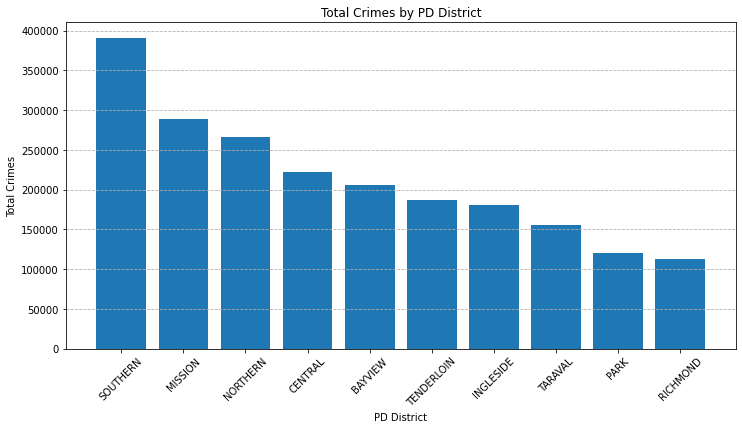

In [0]:
district_count=spark.sql("""
                         select 
                            PdDistrict,
                            count(*) as num_of_crime
                          from sf_crime
                          group by PdDistrict
                          order by num_of_crime desc
                         """)
#display(district_count)

district_count_pd=district_count.filter(district_count.PdDistrict!="NA").toPandas()

district_count_pd=district_count_pd
plt.figure(figsize=(12,6))
plt.bar(district_count_pd['PdDistrict'],district_count_pd['num_of_crime'])
plt.xlabel('PD District')
plt.xticks(rotation=45)
plt.ylabel('Total Crimes')
plt.grid(axis='y',linestyle="--")
plt.title('Total Crimes by PD District')

Based on the analysis, Southern, Mission, Northern are top three PD Districts having the most crimes. Richmond and Park, however, are relatively safer compared to other districts.

##### Analysis on: the number of crime by month in 2015, 2016, 2017, 2018.

Out[10]: Text(0.5, 1.0, 'Total Crimes by Year & Month period')

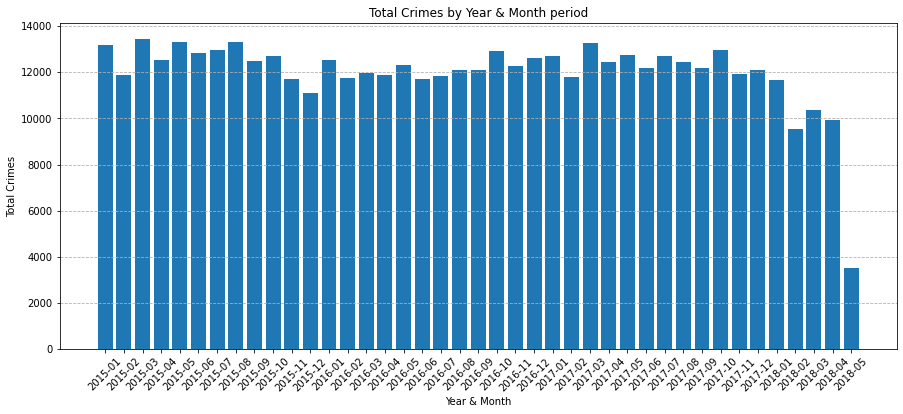

In [0]:
month_crime=spark.sql("""
                      select 
                         right(Date,4) as the_year,
                         left(Date,2) as the_month,
                         concat(right(Date,4),'-',left(Date,2)) as the_year_month,
                         count(*) as num_of_crime
                      from sf_crime
                      where right(Date,4) in ('2015','2016','2017','2018')
                      group by 1,2,3
                      order by the_year_month
                      """)
#display(month_crime)

month_crime_pd=month_crime.toPandas()

plt.figure(figsize=(15,6))
plt.bar(month_crime_pd['the_year_month'],month_crime_pd['num_of_crime'])
plt.xlabel('Year & Month')
plt.xticks(rotation=45)
plt.ylabel('Total Crimes')
plt.grid(axis='y',linestyle="--")
plt.title('Total Crimes by Year & Month period')

Out[11]: Text(0.5, 1.0, 'Average Crimes by Month in 2015~2018 period')

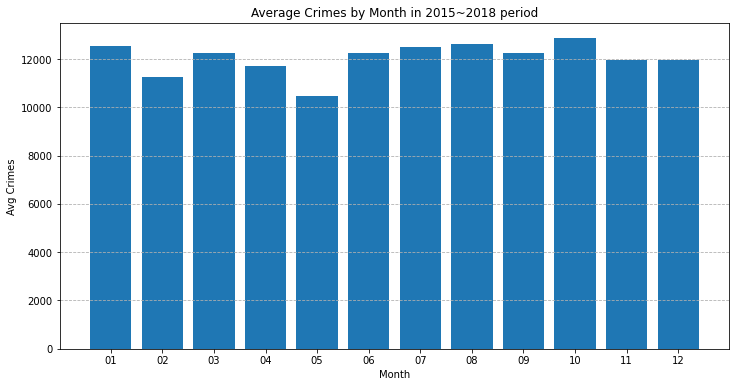

In [0]:
month_crime_g=month_crime.groupBy('the_month').agg(sum('num_of_crime').alias('num_of_crime'),
                                                   count('the_year').alias('count_of_year')).orderBy('the_month',ascending=True)
month_crime_g=month_crime_g.withColumn('avg_crime',round(month_crime_g.num_of_crime/month_crime_g.count_of_year,0))
#month_crime_g=month_crime_g.toDF('the_month','num_of_crime')

month_crime_g_pd=month_crime_g.toPandas()

plt.figure(figsize=(12,6))
plt.bar(month_crime_g_pd['the_month'],month_crime_g_pd['avg_crime'])
plt.xlabel('Month')
#plt.xticks(rotation=45)
plt.ylabel('Avg Crimes')
plt.grid(axis='y',linestyle="--")
plt.title('Average Crimes by Month in 2015~2018 period')

Based on the analysis, looking at the period from 2015 to 2018, since we notice that there's only data till first half of 2018, directly adding the crimes up by month will skew months before June. So we use the average number of crimes for each year in that specific month as the metric here. 

Based on the data, the crime number is usually higher in the summer and winter, especially October. SFPD might need to arrange more police force during this time. Feb and May are relatively a safer month. Looking at the data for each year, the number of crime in 2018 is significantly lower than previous years, which is a good sign for the city.

##### Analysis on: the number of crime with respsect to hours of certian days 
(eg.2015/12/15, 2016/12/15, 2017/12/15)

In [0]:
hour_crime=spark.sql("""
                     select
                        left(time,2) as the_hour,
                        date,
                        count(*) as num_of_crime
                     from sf_crime
                     where Date in ('12/15/2015','12/15/2016','12/15/2017')
                     group by 1,2
                     order by date,the_hour
                     """)
#display(hour_crime)

Out[13]: Text(0.5, 1.0, 'Total Crimes by hour on 12/15 in 2015,2016,2017')

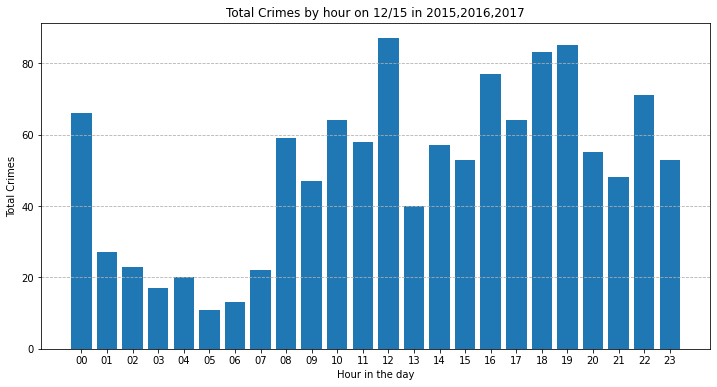

In [0]:
hour_crime_g=hour_crime.groupBy('the_hour').agg(sum('num_of_crime').alias('num_of_crime')).orderBy('the_hour')

hour_crime_g_pd=hour_crime_g.toPandas()

plt.figure(figsize=(12,6))
plt.bar(hour_crime_g_pd['the_hour'],hour_crime_g_pd['num_of_crime'])
plt.xlabel('Hour in the day')
#plt.xticks(rotation=45)
plt.ylabel('Total Crimes')
plt.grid(axis='y',linestyle="--")
plt.title('Total Crimes by hour on 12/15 in 2015,2016,2017')

In [0]:
hour_crime_by_cate=spark.sql("""
                     select
                        left(time,2) as the_hour,
                        category,
                        count(*) as num_of_crime
                     from sf_crime
                     where Date in ('12/15/2015','12/15/2016','12/15/2017')
                     group by 1,2
                     order by the_hour
                     """)
#display(hour_crime_by_cate)

Databricks visualization. Run in Databricks to view.

the_hour category num_of_crime 00 LARCENY/THEFT 14 00 BURGLARY 4 00 FRAUD 4 00 ASSAULT 8 00 ROBBERY 1 00 NON-CRIMINAL 4 00 SUSPICIOUS OCC 3 00 OTHER OFFENSES 15 00 SECONDARY CODES 1 00 DRUG/NARCOTIC 1 00 SEX OFFENSES, FORCIBLE 3 00 RECOVERED VEHICLE 1 00 VANDALISM 2 00 TRESPASS 1 00 BRIBERY 1 00 FORGERY/COUNTERFEITING 1 00 WEAPON LAWS 2 01 LARCENY/THEFT 11 01 SUSPICIOUS OCC 3 01 TRESPASS 1 01 DRUNKENNESS 1 01 ROBBERY 1 01 OTHER OFFENSES 2 01 NON-CRIMINAL 2 01 ASSAULT 2 01 WARRANTS 1 01 MISSING PERSON 2 01 VANDALISM 1 02 NON-CRIMINAL 1 02 WARRANTS 2 02 OTHER OFFENSES 10 02 SECONDARY CODES 1 02 SUSPICIOUS OCC 1 02 VANDALISM 3 02 FRAUD 1 02 DRUNKENNESS 1 02 LARCENY/THEFT 2 02 ASSAULT 1 03 LARCENY/THEFT 2 03 OTHER OFFENSES 3 03 ROBBERY 1 03 VEHICLE THEFT 1 03 ASSAULT 3 03 BURGLARY 3 03 SEX OFFENSES, FORCIBLE 1 03 DRUG/NARCOTIC 1 03 WARRANTS 1 03 NON-CRIMINAL 1 04 LARCENY/THEFT 3 04 WARRANTS 1 04 BURGLARY 3 04 ARSON 1 04 SECONDARY CODES 1 04 OTHER OFFENSES 2 04 NON-CRIMINAL 3 04 ASSAULT 2 04 VANDALISM 1 04 MISSING PERSON 2 04 FRAUD 1 05 NON-CRIMINAL 1 05 ASSAULT 2 05 OTHER OFFENSES 1 05 BRIBERY 1 05 VANDALISM 1 05 SECONDARY CODES 1 05 BURGLARY 1 05 LARCENY/THEFT 1 05 TRESPASS 1 05 VEHICLE THEFT 1 06 WEAPON LAWS 1 06 NON-CRIMINAL 3 06 DISORDERLY CONDUCT 1 06 LARCENY/THEFT 3 06 ASSAULT 4 06 VEHICLE THEFT 1 07 ROBBERY 1 07 NON-CRIMINAL 6 07 VANDALISM 3 07 OTHER OFFENSES 3 07 SUSPICIOUS OCC 2 07 LARCENY/THEFT 3 07 WEAPON LAWS 2 07 BURGLARY 1 07 ASSAULT 1 08 OTHER OFFENSES 6 08 NON-CRIMINAL 9 08 BURGLARY 4 08 VANDALISM 7 08 ASSAULT 8 08 TRESPASS 2 08 SECONDARY CODES 1 08 LARCENY/THEFT 13 08 DISORDERLY CONDUCT 1 08 MISSING PERSON 1 08 VEHICLE THEFT 2 08 FRAUD 1 08 DRUG/NARCOTIC 2 08 WARRANTS 2 09 OTHER OFFENSES 6 09 NON-CRIMINAL 7 09 LARCENY/THEFT 12 09 VANDALISM 3 09 SUSPICIOUS OCC 3 09 SECONDARY CODES 1 09 MISSING PERSON 4 09 FRAUD 1 09 ROBBERY 1 09 BURGLARY 1 09 WEAPON LAWS 1 09 ASSAULT 4 09 VEHICLE THEFT 2 09 SUICIDE 1 10 FRAUD 2 10 OTHER OFFENSES 4 10 NON-CRIMINAL 9 10 EMBEZZLEMENT 1 10 SUSPICIOUS OCC 1 10 FORGERY/COUNTERFEITING 2 10 ROBBERY 1 10 ASSAULT 3 10 LARCENY/THEFT 29 10 BURGLARY 4 10 VANDALISM 2 10 VEHICLE THEFT 2 10 DISORDERLY CONDUCT 1 10 WARRANTS 2 10 MISSING PERSON 1 11 VANDALISM 2 11 WEAPON LAWS 2 11 SUSPICIOUS OCC 3 11 STOLEN PROPERTY 1 11 VEHICLE THEFT 2 11 LARCENY/THEFT 21 11 OTHER OFFENSES 9 11 ROBBERY 1 11 ASSAULT 3 11 NON-CRIMINAL 7 11 BURGLARY 3 11 WARRANTS 2 11 DISORDERLY CONDUCT 1 11 MISSING PERSON 1 12 SUSPICIOUS OCC 3 12 ASSAULT 3 12 MISSING PERSON 1 12 FRAUD 4 12 NON-CRIMINAL 15 12 SECONDARY CODES 1 12 WARRANTS 1 12 OTHER OFFENSES 20 12 VANDALISM 3 12 RECOVERED VEHICLE 1 12 BURGLARY 5 12 LARCENY/THEFT 23 12 FORGERY/COUNTERFEITING 2 12 SEX OFFENSES, FORCIBLE 1 12 VEHICLE THEFT 3 12 STOLEN PROPERTY 1 13 OTHER OFFENSES 3 13 SUSPICIOUS OCC 5 13 WARRANTS 2 13 NON-CRIMINAL 5 13 VANDALISM 5 13 WEAPON LAWS 1 13 BURGLARY 2 13 VEHICLE THEFT 2 13 LARCENY/THEFT 8 13 ASSAULT 4 13 MISSING PERSON 1 13 DRUNKENNESS 1 13 TRESPASS 1 14 ASSAULT 5 14 OTHER OFFENSES 12 14 DRUG/NARCOTIC 2 14 SUSPICIOUS OCC 2 14 SEX OFFENSES, FORCIBLE 1 14 VANDALISM 5 14 WARRANTS 2 14 LARCENY/THEFT 13 14 ROBBERY 2 14 NON-CRIMINAL 11 14 VEHICLE THEFT 1 14 MISSING PERSON 1 15 BURGLARY 2 15 SUSPICIOUS OCC 3 15 VANDALISM 5 15 OTHER OFFENSES 3 15 LARCENY/THEFT 18 15 DRUG/NARCOTIC 1 15 WARRANTS 1 15 NON-CRIMINAL 5 15 ASSAULT 4 15 MISSING PERSON 2 15 WEAPON LAWS 3 15 TRESPASS 1 15 VEHICLE THEFT 1 15 RECOVERED VEHICLE 1 15 FRAUD 3 16 BURGLARY 6 16 NON-CRIMINAL 10 16 VEHICLE THEFT 1 16 ASSAULT 6 16 SUSPICIOUS OCC 2 16 EMBEZZLEMENT 2 16 DRUG/NARCOTIC 1 16 TRESPASS 1 16 OTHER OFFENSES 10 16 VANDALISM 4 16 WARRANTS 3 16 LARCENY/THEFT 25 16 FORGERY/COUNTERFEITING 4 16 RECOVERED VEHICLE 2 17 WARRANTS 1 17 EMBEZZLEMENT 1 17 BURGLARY 6 17 NON-CRIMINAL 7 17 SUSPICIOUS OCC 3 17 OTHER OFFENSES 4 17 VEHICLE THEFT 1 17 ASSAULT 2 17 LARCENY/THEFT 30 17 DRUG/NARCOTIC 2 17 MISSING PERSON 1 17 VANDALISM 3 17 ROBBERY 2 17 TRESPASS 1 18 VEHICLE THEFT 2 18 WEAPON LAWS 3 18 B

Based on the analysis, in a typical day, there usually are more crimes at noon (12:00pm) and early in the night, around 18:00 and 19:00. During these periods, larceny/theft is the most common crime. The number of crime is relatively low in the late night and in the early afternoon.

As a tourist, it's suggested to go back to hotel or avoid walking on the street alone after 18:00. Also tourists should keep a closer eye on their belongings to avoid being robbed. 

##### Analysis on: how to distribute the police force smartly

(1) Step1: Find the top 3 most dangerous districts \
(2) Step2: Find the crime event w.r.t category and time (hour) in the top 3 most dangerous districts \
(3) Step3: Provide data-driven suggestions


If considering whether a district is dangerous or not by looking at the total number of crimes, then the top 3 dangerous districts are: Southern, Mission, Northern. Graph:


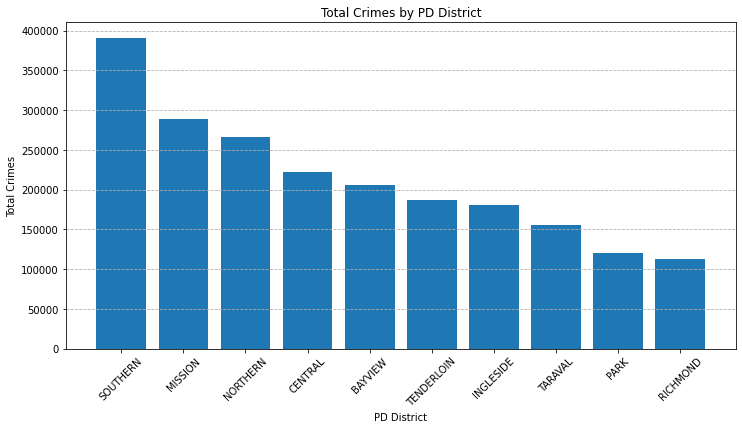

In [0]:
plt.figure(figsize=(12,6))
plt.bar(district_count_pd['PdDistrict'],district_count_pd['num_of_crime'])
plt.xlabel('PD District')
plt.xticks(rotation=45)
plt.ylabel('Total Crimes')
plt.grid(axis='y',linestyle="--")
plt.title('Total Crimes by PD District')

print('If considering whether a district is dangerous or not by looking at the total number of crimes, then the top 3 dangerous districts are: Southern, Mission, Northern. Graph:')

In [0]:
#Analysis for Southern District
hour_crime_cate=spark.sql("""
                     select
                        left(time,2) as the_hour,
                        PdDistrict,
                        category,
                        count(*) as num_of_crime
                     from sf_crime
                     where PdDistrict in ('SOUTHERN')
                    --where Date in ('12/15/2015','12/15/2016','12/15/2017')
                     group by 1,2,3
                     order by PdDistrict,the_hour
                     """)
#display(hour_crime_cate)

Databricks visualization. Run in Databricks to view.

the_hour PdDistrict category num_of_crime 00 SOUTHERN SUSPICIOUS OCC 904 00 SOUTHERN KIDNAPPING 41 00 SOUTHERN WEAPON LAWS 165 00 SOUTHERN ARSON 31 00 SOUTHERN DRUG/NARCOTIC 640 00 SOUTHERN FORGERY/COUNTERFEITING 858 00 SOUTHERN BRIBERY 8 00 SOUTHERN BURGLARY 486 00 SOUTHERN STOLEN PROPERTY 122 00 SOUTHERN ASSAULT 1505 00 SOUTHERN WARRANTS 746 00 SOUTHERN ROBBERY 488 00 SOUTHERN VEHICLE THEFT 496 00 SOUTHERN SECONDARY CODES 183 00 SOUTHERN LIQUOR LAWS 15 00 SOUTHERN EXTORTION 15 00 SOUTHERN VANDALISM 1041 00 SOUTHERN RECOVERED VEHICLE 55 00 SOUTHERN BAD CHECKS 35 00 SOUTHERN TRESPASS 100 00 SOUTHERN MISSING PERSON 400 00 SOUTHERN FRAUD 1172 00 SOUTHERN DRIVING UNDER THE INFLUENCE 85 00 SOUTHERN SEX OFFENSES, FORCIBLE 202 00 SOUTHERN DISORDERLY CONDUCT 37 00 SOUTHERN LOITERING 8 00 SOUTHERN OTHER OFFENSES 2900 00 SOUTHERN LARCENY/THEFT 4156 00 SOUTHERN PROSTITUTION 31 00 SOUTHERN DRUNKENNESS 170 00 SOUTHERN NON-CRIMINAL 2408 00 SOUTHERN EMBEZZLEMENT 131 00 SOUTHERN SUICIDE 3 00 SOUTHERN GAMBLING 3 00 SOUTHERN SEX OFFENSES, NON FORCIBLE 1 01 SOUTHERN PROSTITUTION 15 01 SOUTHERN LARCENY/THEFT 2576 01 SOUTHERN SECONDARY CODES 109 01 SOUTHERN KIDNAPPING 40 01 SOUTHERN WARRANTS 466 01 SOUTHERN ARSON 27 01 SOUTHERN VANDALISM 703 01 SOUTHERN SUICIDE 5 01 SOUTHERN MISSING PERSON 146 01 SOUTHERN LOITERING 3 01 SOUTHERN SEX OFFENSES, FORCIBLE 92 01 SOUTHERN DISORDERLY CONDUCT 24 01 SOUTHERN WEAPON LAWS 113 01 SOUTHERN ASSAULT 1379 01 SOUTHERN FRAUD 144 01 SOUTHERN NON-CRIMINAL 1240 01 SOUTHERN DRUG/NARCOTIC 387 01 SOUTHERN FORGERY/COUNTERFEITING 49 01 SOUTHERN LIQUOR LAWS 10 01 SOUTHERN OTHER OFFENSES 1398 01 SOUTHERN BAD CHECKS 1 01 SOUTHERN ROBBERY 518 01 SOUTHERN SUSPICIOUS OCC 399 01 SOUTHERN TRESPASS 64 01 SOUTHERN BURGLARY 359 01 SOUTHERN DRIVING UNDER THE INFLUENCE 101 01 SOUTHERN STOLEN PROPERTY 85 01 SOUTHERN RECOVERED VEHICLE 49 01 SOUTHERN DRUNKENNESS 158 01 SOUTHERN VEHICLE THEFT 308 01 SOUTHERN BRIBERY 3 01 SOUTHERN EXTORTION 1 01 SOUTHERN EMBEZZLEMENT 3 02 SOUTHERN STOLEN PROPERTY 46 02 SOUTHERN OTHER OFFENSES 1061 02 SOUTHERN NON-CRIMINAL 986 02 SOUTHERN FRAUD 108 02 SOUTHERN ROBBERY 556 02 SOUTHERN PROSTITUTION 10 02 SOUTHERN WARRANTS 356 02 SOUTHERN DRIVING UNDER THE INFLUENCE 84 02 SOUTHERN LIQUOR LAWS 10 02 SOUTHERN VEHICLE THEFT 304 02 SOUTHERN BURGLARY 399 02 SOUTHERN RECOVERED VEHICLE 26 02 SOUTHERN DISORDERLY CONDUCT 25 02 SOUTHERN ARSON 25 02 SOUTHERN VANDALISM 648 02 SOUTHERN ASSAULT 1349 02 SOUTHERN KIDNAPPING 36 02 SOUTHERN SEX OFFENSES, FORCIBLE 99 02 SOUTHERN MISSING PERSON 116 02 SOUTHERN SUSPICIOUS OCC 364 02 SOUTHERN DRUNKENNESS 127 02 SOUTHERN DRUG/NARCOTIC 277 02 SOUTHERN FORGERY/COUNTERFEITING 26 02 SOUTHERN SECONDARY CODES 111 02 SOUTHERN TRESPASS 67 02 SOUTHERN LARCENY/THEFT 1778 02 SOUTHERN WEAPON LAWS 99 02 SOUTHERN LOITERING 2 02 SOUTHERN EMBEZZLEMENT 2 02 SOUTHERN SUICIDE 5 02 SOUTHERN EXTORTION 1 02 SOUTHERN BAD CHECKS 1 02 SOUTHERN BRIBERY 3 03 SOUTHERN DRUG/NARCOTIC 202 03 SOUTHERN SUICIDE 2 03 SOUTHERN PROSTITUTION 10 03 SOUTHERN LARCENY/THEFT 950 03 SOUTHERN VANDALISM 469 03 SOUTHERN ROBBERY 325 03 SOUTHERN RECOVERED VEHICLE 34 03 SOUTHERN SUSPICIOUS OCC 243 03 SOUTHERN SECONDARY CODES 65 03 SOUTHERN WARRANTS 272 03 SOUTHERN BURGLARY 417 03 SOUTHERN MISSING PERSON 56 03 SOUTHERN ASSAULT 619 03 SOUTHERN KIDNAPPING 25 03 SOUTHERN TRESPASS 45 03 SOUTHERN VEHICLE THEFT 142 03 SOUTHERN OTHER OFFENSES 701 03 SOUTHERN STOLEN PROPERTY 37 03 SOUTHERN WEAPON LAWS 58 03 SOUTHERN FRAUD 56 03 SOUTHERN SEX OFFENSES, FORCIBLE 76 03 SOUTHERN DISORDERLY CONDUCT 18 03 SOUTHERN NON-CRIMINAL 614 03 SOUTHERN DRUNKENNESS 44 03 SOUTHERN ARSON 21 03 SOUTHERN FORGERY/COUNTERFEITING 27 03 SOUTHERN DRIVING UNDER THE INFLUENCE 41 03 SOUTHERN LOITERING 3 03 SOUTHERN EXTORTION 2 03 SOUTHERN PORNOGRAPHY/OBSCENE MAT 1 03 SOUTHERN LIQUOR LAWS 3 03 SOUTHERN BRIBERY 1 03 SOUTHERN EMBEZZLEMENT 5 04 SOUTHERN DRIVING UNDER THE INFLUENCE 12 04 SOUTHERN MISSING PERSON 40 04 SOUTHERN DRUG/NARCOTIC 131 04 SOUTHERN SEX OFFENSES, FORCI

In [0]:
#Analysis for Mission District
hour_crime_cate2=spark.sql("""
                     select
                        left(time,2) as the_hour,
                        PdDistrict,
                        category,
                        count(*) as num_of_crime
                     from sf_crime
                     where PdDistrict in ('MISSION')
                    --where Date in ('12/15/2015','12/15/2016','12/15/2017')
                     group by 1,2,3
                     order by PdDistrict,the_hour
                     """)
#display(hour_crime_cate2)

Databricks visualization. Run in Databricks to view.

the_hour PdDistrict category num_of_crime 00 MISSION DRUNKENNESS 155 00 MISSION VANDALISM 856 00 MISSION LIQUOR LAWS 36 00 MISSION ARSON 35 00 MISSION BRIBERY 9 00 MISSION NON-CRIMINAL 1528 00 MISSION EMBEZZLEMENT 64 00 MISSION BURGLARY 481 00 MISSION BAD CHECKS 13 00 MISSION OTHER OFFENSES 2703 00 MISSION MISSING PERSON 215 00 MISSION FORGERY/COUNTERFEITING 358 00 MISSION DISORDERLY CONDUCT 188 00 MISSION TRESPASS 98 00 MISSION RECOVERED VEHICLE 40 00 MISSION EXTORTION 9 00 MISSION LOITERING 23 00 MISSION DRUG/NARCOTIC 640 00 MISSION ASSAULT 1570 00 MISSION STOLEN PROPERTY 71 00 MISSION VEHICLE THEFT 614 00 MISSION DRIVING UNDER THE INFLUENCE 115 00 MISSION SECONDARY CODES 194 00 MISSION PROSTITUTION 706 00 MISSION FRAUD 611 00 MISSION SEX OFFENSES, FORCIBLE 156 00 MISSION WARRANTS 666 00 MISSION ROBBERY 547 00 MISSION WEAPON LAWS 188 00 MISSION SUSPICIOUS OCC 670 00 MISSION LARCENY/THEFT 2553 00 MISSION GAMBLING 6 00 MISSION KIDNAPPING 40 00 MISSION SUICIDE 7 00 MISSION SEX OFFENSES, NON FORCIBLE 3 01 MISSION RECOVERED VEHICLE 27 01 MISSION WARRANTS 494 01 MISSION BURGLARY 301 01 MISSION LOITERING 14 01 MISSION FORGERY/COUNTERFEITING 27 01 MISSION KIDNAPPING 44 01 MISSION PROSTITUTION 459 01 MISSION DRUNKENNESS 134 01 MISSION NON-CRIMINAL 958 01 MISSION OTHER OFFENSES 1491 01 MISSION TRESPASS 71 01 MISSION SECONDARY CODES 122 01 MISSION SUSPICIOUS OCC 353 01 MISSION SEX OFFENSES, FORCIBLE 79 01 MISSION VEHICLE THEFT 452 01 MISSION STOLEN PROPERTY 61 01 MISSION WEAPON LAWS 157 01 MISSION FRAUD 145 01 MISSION VANDALISM 613 01 MISSION DISORDERLY CONDUCT 129 01 MISSION ROBBERY 644 01 MISSION DRIVING UNDER THE INFLUENCE 93 01 MISSION LARCENY/THEFT 1822 01 MISSION MISSING PERSON 114 01 MISSION DRUG/NARCOTIC 460 01 MISSION ASSAULT 1483 01 MISSION LIQUOR LAWS 15 01 MISSION ARSON 23 01 MISSION EXTORTION 2 01 MISSION SUICIDE 7 01 MISSION BAD CHECKS 1 01 MISSION BRIBERY 5 02 MISSION BURGLARY 315 02 MISSION SECONDARY CODES 117 02 MISSION ROBBERY 782 02 MISSION DRUG/NARCOTIC 360 02 MISSION WEAPON LAWS 119 02 MISSION VEHICLE THEFT 317 02 MISSION BRIBERY 7 02 MISSION VANDALISM 621 02 MISSION RECOVERED VEHICLE 25 02 MISSION PROSTITUTION 325 02 MISSION MISSING PERSON 72 02 MISSION WARRANTS 408 02 MISSION DISORDERLY CONDUCT 96 02 MISSION DRUNKENNESS 96 02 MISSION FRAUD 75 02 MISSION ARSON 28 02 MISSION DRIVING UNDER THE INFLUENCE 80 02 MISSION STOLEN PROPERTY 44 02 MISSION NON-CRIMINAL 746 02 MISSION LOITERING 9 02 MISSION KIDNAPPING 41 02 MISSION TRESPASS 105 02 MISSION LIQUOR LAWS 10 02 MISSION ASSAULT 1258 02 MISSION SEX OFFENSES, FORCIBLE 92 02 MISSION SUSPICIOUS OCC 304 02 MISSION LARCENY/THEFT 1013 02 MISSION OTHER OFFENSES 1211 02 MISSION FORGERY/COUNTERFEITING 10 02 MISSION EMBEZZLEMENT 2 02 MISSION EXTORTION 1 02 MISSION SUICIDE 3 02 MISSION BAD CHECKS 1 03 MISSION PROSTITUTION 179 03 MISSION ARSON 36 03 MISSION BRIBERY 5 03 MISSION ASSAULT 553 03 MISSION VEHICLE THEFT 218 03 MISSION STOLEN PROPERTY 47 03 MISSION KIDNAPPING 25 03 MISSION WARRANTS 267 03 MISSION RECOVERED VEHICLE 19 03 MISSION SEX OFFENSES, FORCIBLE 68 03 MISSION DISORDERLY CONDUCT 53 03 MISSION SUSPICIOUS OCC 221 03 MISSION NON-CRIMINAL 470 03 MISSION VANDALISM 387 03 MISSION FRAUD 48 03 MISSION LARCENY/THEFT 648 03 MISSION DRIVING UNDER THE INFLUENCE 36 03 MISSION SECONDARY CODES 72 03 MISSION ROBBERY 408 03 MISSION MISSING PERSON 47 03 MISSION OTHER OFFENSES 843 03 MISSION WEAPON LAWS 90 03 MISSION TRESPASS 77 03 MISSION FORGERY/COUNTERFEITING 13 03 MISSION BURGLARY 371 03 MISSION DRUNKENNESS 46 03 MISSION DRUG/NARCOTIC 210 03 MISSION LIQUOR LAWS 5 03 MISSION LOITERING 2 03 MISSION SUICIDE 1 03 MISSION EMBEZZLEMENT 1 04 MISSION NON-CRIMINAL 329 04 MISSION DRIVING UNDER THE INFLUENCE 16 04 MISSION MISSING PERSON 41 04 MISSION ARSON 27 04 MISSION FORGERY/COUNTERFEITING 14 04 MISSION WARRANTS 201 04 MISSION VEHICLE THEFT 163 04 MISSION DRUG/NARCOTIC 131 04 MISSION SECONDARY CODES 37 04 MISSION FRAUD 48 04 MISSION PROSTITUTION 131 04 MISSION DISORDERLY CONDUCT 43 04 MI

In [0]:
#Analysis for Northern District
hour_crime_cate3=spark.sql("""
                     select
                        left(time,2) as the_hour,
                        PdDistrict,
                        category,
                        count(*) as num_of_crime
                     from sf_crime
                     where PdDistrict in ('NORTHERN')
                    --where Date in ('12/15/2015','12/15/2016','12/15/2017')
                     group by 1,2,3
                     order by PdDistrict,the_hour
                     """)
#display(hour_crime_cate3)

Databricks visualization. Run in Databricks to view.

the_hour PdDistrict category num_of_crime 00 NORTHERN KIDNAPPING 35 00 NORTHERN PROSTITUTION 370 00 NORTHERN LOITERING 17 00 NORTHERN STOLEN PROPERTY 104 00 NORTHERN ASSAULT 1045 00 NORTHERN ARSON 18 00 NORTHERN BAD CHECKS 31 00 NORTHERN RECOVERED VEHICLE 43 00 NORTHERN TRESPASS 62 00 NORTHERN BURGLARY 618 00 NORTHERN DRUNKENNESS 75 00 NORTHERN EMBEZZLEMENT 85 00 NORTHERN WARRANTS 521 00 NORTHERN SEX OFFENSES, FORCIBLE 92 00 NORTHERN DISORDERLY CONDUCT 76 00 NORTHERN LIQUOR LAWS 12 00 NORTHERN WEAPON LAWS 113 00 NORTHERN OTHER OFFENSES 2029 00 NORTHERN NON-CRIMINAL 1267 00 NORTHERN VEHICLE THEFT 458 00 NORTHERN SECONDARY CODES 142 00 NORTHERN MISSING PERSON 169 00 NORTHERN DRIVING UNDER THE INFLUENCE 72 00 NORTHERN FORGERY/COUNTERFEITING 428 00 NORTHERN LARCENY/THEFT 3373 00 NORTHERN SUSPICIOUS OCC 574 00 NORTHERN VANDALISM 757 00 NORTHERN FRAUD 706 00 NORTHERN ROBBERY 365 00 NORTHERN DRUG/NARCOTIC 476 00 NORTHERN EXTORTION 5 00 NORTHERN SUICIDE 2 00 NORTHERN BRIBERY 3 00 NORTHERN GAMBLING 4 00 NORTHERN PORNOGRAPHY/OBSCENE MAT 1 01 NORTHERN TRESPASS 45 01 NORTHERN BAD CHECKS 1 01 NORTHERN DISORDERLY CONDUCT 72 01 NORTHERN RECOVERED VEHICLE 27 01 NORTHERN SUSPICIOUS OCC 244 01 NORTHERN ROBBERY 372 01 NORTHERN KIDNAPPING 27 01 NORTHERN SEX OFFENSES, FORCIBLE 81 01 NORTHERN WEAPON LAWS 84 01 NORTHERN ASSAULT 1078 01 NORTHERN WARRANTS 453 01 NORTHERN ARSON 27 01 NORTHERN OTHER OFFENSES 1013 01 NORTHERN VANDALISM 600 01 NORTHERN DRIVING UNDER THE INFLUENCE 80 01 NORTHERN STOLEN PROPERTY 73 01 NORTHERN MISSING PERSON 95 01 NORTHERN VEHICLE THEFT 369 01 NORTHERN LOITERING 21 01 NORTHERN LARCENY/THEFT 2246 01 NORTHERN SECONDARY CODES 87 01 NORTHERN BRIBERY 3 01 NORTHERN DRUNKENNESS 77 01 NORTHERN FRAUD 125 01 NORTHERN PROSTITUTION 345 01 NORTHERN FORGERY/COUNTERFEITING 16 01 NORTHERN NON-CRIMINAL 750 01 NORTHERN DRUG/NARCOTIC 309 01 NORTHERN BURGLARY 404 01 NORTHERN GAMBLING 1 01 NORTHERN EXTORTION 1 01 NORTHERN SUICIDE 1 01 NORTHERN LIQUOR LAWS 3 01 NORTHERN EMBEZZLEMENT 1 02 NORTHERN DRUG/NARCOTIC 310 02 NORTHERN DRIVING UNDER THE INFLUENCE 99 02 NORTHERN DISORDERLY CONDUCT 91 02 NORTHERN ROBBERY 411 02 NORTHERN LARCENY/THEFT 1274 02 NORTHERN ARSON 31 02 NORTHERN VEHICLE THEFT 268 02 NORTHERN SUICIDE 5 02 NORTHERN DRUNKENNESS 71 02 NORTHERN LOITERING 13 02 NORTHERN SUSPICIOUS OCC 203 02 NORTHERN VANDALISM 511 02 NORTHERN ASSAULT 903 02 NORTHERN WARRANTS 448 02 NORTHERN OTHER OFFENSES 1007 02 NORTHERN FORGERY/COUNTERFEITING 28 02 NORTHERN BURGLARY 438 02 NORTHERN SECONDARY CODES 65 02 NORTHERN STOLEN PROPERTY 75 02 NORTHERN TRESPASS 69 02 NORTHERN MISSING PERSON 83 02 NORTHERN NON-CRIMINAL 603 02 NORTHERN KIDNAPPING 29 02 NORTHERN WEAPON LAWS 105 02 NORTHERN FRAUD 100 02 NORTHERN SEX OFFENSES, FORCIBLE 70 02 NORTHERN RECOVERED VEHICLE 26 02 NORTHERN PROSTITUTION 295 02 NORTHERN BRIBERY 2 02 NORTHERN LIQUOR LAWS 3 02 NORTHERN EXTORTION 1 03 NORTHERN SUSPICIOUS OCC 162 03 NORTHERN ROBBERY 255 03 NORTHERN VEHICLE THEFT 192 03 NORTHERN ASSAULT 450 03 NORTHERN MISSING PERSON 59 03 NORTHERN LARCENY/THEFT 821 03 NORTHERN SECONDARY CODES 60 03 NORTHERN FORGERY/COUNTERFEITING 21 03 NORTHERN PROSTITUTION 233 03 NORTHERN SEX OFFENSES, FORCIBLE 44 03 NORTHERN NON-CRIMINAL 359 03 NORTHERN KIDNAPPING 18 03 NORTHERN DISORDERLY CONDUCT 69 03 NORTHERN RECOVERED VEHICLE 31 03 NORTHERN LOITERING 22 03 NORTHERN OTHER OFFENSES 785 03 NORTHERN TRESPASS 52 03 NORTHERN WEAPON LAWS 51 03 NORTHERN STOLEN PROPERTY 59 03 NORTHERN BURGLARY 441 03 NORTHERN DRUNKENNESS 38 03 NORTHERN VANDALISM 367 03 NORTHERN FRAUD 56 03 NORTHERN DRUG/NARCOTIC 195 03 NORTHERN DRIVING UNDER THE INFLUENCE 40 03 NORTHERN ARSON 38 03 NORTHERN WARRANTS 411 03 NORTHERN SUICIDE 6 03 NORTHERN GAMBLING 1 03 NORTHERN LIQUOR LAWS 4 04 NORTHERN DRUG/NARCOTIC 182 04 NORTHERN PROSTITUTION 192 04 NORTHERN STOLEN PROPERTY 47 04 NORTHERN WARRANTS 279 04 NORTHERN WEAPON LAWS 39 04 NORTHERN OTHER OFFENSES 587 04 NORTHERN BURGLARY 363 04 NORTHERN VEHICLE THEFT 131 04 NORTHERN KIDNAPPING 14 04 NORTHER

In [0]:
hour_crime_cate.createOrReplaceTempView('southern')
hour_crime_cate2.createOrReplaceTempView('mission')
hour_crime_cate3.createOrReplaceTempView('northern')

compare=spark.sql("""
                  select *
                  from (select *, row_number() over(partition by the_hour order by num_of_crime desc) as the_rank from southern)
                  where the_rank<=5

                  union all

                  select *
                  from (select *, row_number() over(partition by the_hour order by num_of_crime desc) as the_rank from mission)
                  where the_rank<=5

                  union all

                  select *
                  from (select *, row_number() over(partition by the_hour order by num_of_crime desc) as the_rank from northern)
                  where the_rank<=5
                  """)

In [0]:
#display(compare.filter(compare.PdDistrict=='SOUTHERN'))

Databricks visualization. Run in Databricks to view.

the_hour PdDistrict category num_of_crime the_rank 00 SOUTHERN LARCENY/THEFT 4156 1 00 SOUTHERN OTHER OFFENSES 2900 2 00 SOUTHERN NON-CRIMINAL 2408 3 00 SOUTHERN ASSAULT 1505 4 00 SOUTHERN FRAUD 1172 5 01 SOUTHERN LARCENY/THEFT 2576 1 01 SOUTHERN OTHER OFFENSES 1398 2 01 SOUTHERN ASSAULT 1379 3 01 SOUTHERN NON-CRIMINAL 1240 4 01 SOUTHERN VANDALISM 703 5 02 SOUTHERN LARCENY/THEFT 1778 1 02 SOUTHERN ASSAULT 1349 2 02 SOUTHERN OTHER OFFENSES 1061 3 02 SOUTHERN NON-CRIMINAL 986 4 02 SOUTHERN VANDALISM 648 5 03 SOUTHERN LARCENY/THEFT 950 1 03 SOUTHERN OTHER OFFENSES 701 2 03 SOUTHERN ASSAULT 619 3 03 SOUTHERN NON-CRIMINAL 614 4 03 SOUTHERN VANDALISM 469 5 04 SOUTHERN LARCENY/THEFT 627 1 04 SOUTHERN OTHER OFFENSES 557 2 04 SOUTHERN NON-CRIMINAL 475 3 04 SOUTHERN ASSAULT 366 4 04 SOUTHERN BURGLARY 359 5 05 SOUTHERN LARCENY/THEFT 644 1 05 SOUTHERN NON-CRIMINAL 447 2 05 SOUTHERN OTHER OFFENSES 384 3 05 SOUTHERN BURGLARY 327 4 05 SOUTHERN ASSAULT 304 5 06 SOUTHERN LARCENY/THEFT 1075 1 06 SOUTHERN NON-CRIMINAL 803 2 06 SOUTHERN OTHER OFFENSES 643 3 06 SOUTHERN ASSAULT 465 4 06 SOUTHERN VANDALISM 351 5 07 SOUTHERN LARCENY/THEFT 1602 1 07 SOUTHERN OTHER OFFENSES 1447 2 07 SOUTHERN NON-CRIMINAL 1396 3 07 SOUTHERN WARRANTS 710 4 07 SOUTHERN ASSAULT 676 5 08 SOUTHERN LARCENY/THEFT 2848 1 08 SOUTHERN OTHER OFFENSES 2232 2 08 SOUTHERN NON-CRIMINAL 2180 3 08 SOUTHERN ASSAULT 965 4 08 SOUTHERN WARRANTS 929 5 09 SOUTHERN LARCENY/THEFT 3630 1 09 SOUTHERN OTHER OFFENSES 2586 2 09 SOUTHERN NON-CRIMINAL 2451 3 09 SOUTHERN WARRANTS 1220 4 09 SOUTHERN ASSAULT 1087 5 10 SOUTHERN LARCENY/THEFT 4558 1 10 SOUTHERN NON-CRIMINAL 2729 2 10 SOUTHERN OTHER OFFENSES 2417 3 10 SOUTHERN WARRANTS 1282 4 10 SOUTHERN ASSAULT 1224 5 11 SOUTHERN LARCENY/THEFT 5131 1 11 SOUTHERN NON-CRIMINAL 2660 2 11 SOUTHERN OTHER OFFENSES 2366 3 11 SOUTHERN ASSAULT 1285 4 11 SOUTHERN WARRANTS 1284 5 12 SOUTHERN LARCENY/THEFT 6406 1 12 SOUTHERN NON-CRIMINAL 3657 2 12 SOUTHERN OTHER OFFENSES 2908 3 12 SOUTHERN ASSAULT 1523 4 12 SOUTHERN WARRANTS 1316 5 13 SOUTHERN LARCENY/THEFT 6111 1 13 SOUTHERN NON-CRIMINAL 2892 2 13 SOUTHERN OTHER OFFENSES 2641 3 13 SOUTHERN DRUG/NARCOTIC 1486 4 13 SOUTHERN WARRANTS 1401 5 14 SOUTHERN LARCENY/THEFT 6178 1 14 SOUTHERN NON-CRIMINAL 2871 2 14 SOUTHERN OTHER OFFENSES 2548 3 14 SOUTHERN DRUG/NARCOTIC 1622 4 14 SOUTHERN ASSAULT 1469 5 15 SOUTHERN LARCENY/THEFT 6308 1 15 SOUTHERN NON-CRIMINAL 2945 2 15 SOUTHERN OTHER OFFENSES 2726 3 15 SOUTHERN ASSAULT 1547 4 15 SOUTHERN DRUG/NARCOTIC 1428 5 16 SOUTHERN LARCENY/THEFT 6670 1 16 SOUTHERN OTHER OFFENSES 3122 2 16 SOUTHERN NON-CRIMINAL 2986 3 16 SOUTHERN ASSAULT 1606 4 16 SOUTHERN WARRANTS 1445 5 17 SOUTHERN LARCENY/THEFT 7842 1 17 SOUTHERN OTHER OFFENSES 3150 2 17 SOUTHERN NON-CRIMINAL 2756 3 17 SOUTHERN ASSAULT 1591 4 17 SOUTHERN DRUG/NARCOTIC 1478 5 18 SOUTHERN LARCENY/THEFT 9580 1 18 SOUTHERN OTHER OFFENSES 2828 2 18 SOUTHERN NON-CRIMINAL 2632 3 18 SOUTHERN ASSAULT 1493 4 18 SOUTHERN DRUG/NARCOTIC 1378 5 19 SOUTHERN LARCENY/THEFT 9161 1 19 SOUTHERN OTHER OFFENSES 2466 2 19 SOUTHERN NON-CRIMINAL 2367 3 19 SOUTHERN ASSAULT 1429 4 19 SOUTHERN VANDALISM 1152 5 20 SOUTHERN LARCENY/THEFT 7378 1 20 SOUTHERN NON-CRIMINAL 2172 2 20 SOUTHERN OTHER OFFENSES 2131 3 20 SOUTHERN ASSAULT 1337 4 20 SOUTHERN VANDALISM 1092 5 21 SOUTHERN LARCENY/THEFT 5884 1 21 SOUTHERN OTHER OFFENSES 2314 2 21 SOUTHERN NON-CRIMINAL 2050 3 21 SOUTHERN ASSAULT 1329 4 21 SOUTHERN VANDALISM 1048 5 22 SOUTHERN LARCENY/THEFT 5952 1 22 SOUTHERN OTHER OFFENSES 2552 2 22 SOUTHERN NON-CRIMINAL 1997 3 22 SOUTHERN ASSAULT 1280 4 22 SOUTHERN VANDALISM 1174 5 23 SOUTHERN LARCENY/THEFT 5667 1 23 SOUTHERN OTHER OFFENSES 2404 2 23 SOUTHERN NON-CRIMINAL 1990 3 23 SOUTHERN ASSAULT 1240 4 23 SOUTHERN VANDALISM 1144 5

In [0]:
#display(compare.filter(compare.PdDistrict=='MISSION'))

Databricks visualization. Run in Databricks to view.

the_hour PdDistrict category num_of_crime the_rank 00 MISSION OTHER OFFENSES 2703 1 00 MISSION LARCENY/THEFT 2553 2 00 MISSION ASSAULT 1570 3 00 MISSION NON-CRIMINAL 1528 4 00 MISSION VANDALISM 856 5 01 MISSION LARCENY/THEFT 1822 1 01 MISSION OTHER OFFENSES 1491 2 01 MISSION ASSAULT 1483 3 01 MISSION NON-CRIMINAL 958 4 01 MISSION ROBBERY 644 5 02 MISSION ASSAULT 1258 1 02 MISSION OTHER OFFENSES 1211 2 02 MISSION LARCENY/THEFT 1013 3 02 MISSION ROBBERY 782 4 02 MISSION NON-CRIMINAL 746 5 03 MISSION OTHER OFFENSES 843 1 03 MISSION LARCENY/THEFT 648 2 03 MISSION ASSAULT 553 3 03 MISSION NON-CRIMINAL 470 4 03 MISSION ROBBERY 408 5 04 MISSION OTHER OFFENSES 600 1 04 MISSION LARCENY/THEFT 428 2 04 MISSION ASSAULT 410 3 04 MISSION NON-CRIMINAL 329 4 04 MISSION BURGLARY 310 5 05 MISSION OTHER OFFENSES 423 1 05 MISSION LARCENY/THEFT 344 2 05 MISSION NON-CRIMINAL 328 3 05 MISSION ASSAULT 272 4 05 MISSION BURGLARY 255 5 06 MISSION OTHER OFFENSES 650 1 06 MISSION NON-CRIMINAL 649 2 06 MISSION LARCENY/THEFT 560 3 06 MISSION ASSAULT 339 4 06 MISSION WARRANTS 297 5 07 MISSION OTHER OFFENSES 1329 1 07 MISSION LARCENY/THEFT 865 2 07 MISSION NON-CRIMINAL 811 3 07 MISSION DRUG/NARCOTIC 552 4 07 MISSION WARRANTS 508 5 08 MISSION OTHER OFFENSES 1855 1 08 MISSION LARCENY/THEFT 1363 2 08 MISSION NON-CRIMINAL 1262 3 08 MISSION ASSAULT 726 4 08 MISSION DRUG/NARCOTIC 678 5 09 MISSION OTHER OFFENSES 2175 1 09 MISSION LARCENY/THEFT 1470 2 09 MISSION NON-CRIMINAL 1379 3 09 MISSION ASSAULT 870 4 09 MISSION DRUG/NARCOTIC 836 5 10 MISSION OTHER OFFENSES 2232 1 10 MISSION LARCENY/THEFT 1700 2 10 MISSION NON-CRIMINAL 1560 3 10 MISSION DRUG/NARCOTIC 1018 4 10 MISSION ASSAULT 902 5 11 MISSION OTHER OFFENSES 2220 1 11 MISSION LARCENY/THEFT 1779 2 11 MISSION NON-CRIMINAL 1681 3 11 MISSION DRUG/NARCOTIC 1167 4 11 MISSION ASSAULT 961 5 12 MISSION OTHER OFFENSES 3028 1 12 MISSION LARCENY/THEFT 2424 2 12 MISSION NON-CRIMINAL 2269 3 12 MISSION ASSAULT 1175 4 12 MISSION DRUG/NARCOTIC 1163 5 13 MISSION OTHER OFFENSES 2185 1 13 MISSION LARCENY/THEFT 2014 2 13 MISSION NON-CRIMINAL 1771 3 13 MISSION ASSAULT 1140 4 13 MISSION DRUG/NARCOTIC 1135 5 14 MISSION OTHER OFFENSES 2234 1 14 MISSION LARCENY/THEFT 2203 2 14 MISSION NON-CRIMINAL 1647 3 14 MISSION ASSAULT 1175 4 14 MISSION DRUG/NARCOTIC 1169 5 15 MISSION LARCENY/THEFT 2456 1 15 MISSION OTHER OFFENSES 2303 2 15 MISSION NON-CRIMINAL 1824 3 15 MISSION ASSAULT 1279 4 15 MISSION DRUG/NARCOTIC 1082 5 16 MISSION OTHER OFFENSES 2801 1 16 MISSION LARCENY/THEFT 2582 2 16 MISSION NON-CRIMINAL 1872 3 16 MISSION ASSAULT 1306 4 16 MISSION DRUG/NARCOTIC 1175 5 17 MISSION OTHER OFFENSES 2873 1 17 MISSION LARCENY/THEFT 2870 2 17 MISSION NON-CRIMINAL 1749 3 17 MISSION ASSAULT 1341 4 17 MISSION DRUG/NARCOTIC 1338 5 18 MISSION LARCENY/THEFT 3617 1 18 MISSION OTHER OFFENSES 2611 2 18 MISSION NON-CRIMINAL 1694 3 18 MISSION VEHICLE THEFT 1429 4 18 MISSION ASSAULT 1349 5 19 MISSION LARCENY/THEFT 3467 1 19 MISSION OTHER OFFENSES 2232 2 19 MISSION NON-CRIMINAL 1482 3 19 MISSION ASSAULT 1289 4 19 MISSION VEHICLE THEFT 1285 5 20 MISSION LARCENY/THEFT 3333 1 20 MISSION OTHER OFFENSES 1903 2 20 MISSION NON-CRIMINAL 1401 3 20 MISSION VEHICLE THEFT 1363 4 20 MISSION ASSAULT 1346 5 21 MISSION LARCENY/THEFT 3003 1 21 MISSION OTHER OFFENSES 1852 2 21 MISSION NON-CRIMINAL 1418 3 21 MISSION ASSAULT 1338 4 21 MISSION VEHICLE THEFT 1258 5 22 MISSION LARCENY/THEFT 3121 1 22 MISSION OTHER OFFENSES 2300 2 22 MISSION NON-CRIMINAL 1406 3 22 MISSION ASSAULT 1388 4 22 MISSION VEHICLE THEFT 1344 5 23 MISSION LARCENY/THEFT 3176 1 23 MISSION OTHER OFFENSES 2323 2 23 MISSION NON-CRIMINAL 1366 3 23 MISSION ASSAULT 1357 4 23 MISSION VEHICLE THEFT 1216 5

In [0]:
#display(compare.filter(compare.PdDistrict=='NORTHERN'))

Databricks visualization. Run in Databricks to view.

the_hour PdDistrict category num_of_crime the_rank 00 NORTHERN LARCENY/THEFT 3373 1 00 NORTHERN OTHER OFFENSES 2029 2 00 NORTHERN NON-CRIMINAL 1267 3 00 NORTHERN ASSAULT 1045 4 00 NORTHERN VANDALISM 757 5 01 NORTHERN LARCENY/THEFT 2246 1 01 NORTHERN ASSAULT 1078 2 01 NORTHERN OTHER OFFENSES 1013 3 01 NORTHERN NON-CRIMINAL 750 4 01 NORTHERN VANDALISM 600 5 02 NORTHERN LARCENY/THEFT 1274 1 02 NORTHERN OTHER OFFENSES 1007 2 02 NORTHERN ASSAULT 903 3 02 NORTHERN NON-CRIMINAL 603 4 02 NORTHERN VANDALISM 511 5 03 NORTHERN LARCENY/THEFT 821 1 03 NORTHERN OTHER OFFENSES 785 2 03 NORTHERN ASSAULT 450 3 03 NORTHERN BURGLARY 441 4 03 NORTHERN WARRANTS 411 5 04 NORTHERN OTHER OFFENSES 587 1 04 NORTHERN LARCENY/THEFT 487 2 04 NORTHERN BURGLARY 363 3 04 NORTHERN WARRANTS 279 4 04 NORTHERN NON-CRIMINAL 261 5 05 NORTHERN LARCENY/THEFT 502 1 05 NORTHERN OTHER OFFENSES 407 2 05 NORTHERN BURGLARY 366 3 05 NORTHERN PROSTITUTION 319 4 05 NORTHERN NON-CRIMINAL 243 5 06 NORTHERN LARCENY/THEFT 843 1 06 NORTHERN NON-CRIMINAL 487 2 06 NORTHERN OTHER OFFENSES 450 3 06 NORTHERN BURGLARY 343 4 06 NORTHERN ASSAULT 285 5 07 NORTHERN LARCENY/THEFT 1313 1 07 NORTHERN OTHER OFFENSES 747 2 07 NORTHERN NON-CRIMINAL 709 3 07 NORTHERN BURGLARY 486 4 07 NORTHERN ASSAULT 420 5 08 NORTHERN LARCENY/THEFT 2067 1 08 NORTHERN OTHER OFFENSES 1309 2 08 NORTHERN NON-CRIMINAL 1120 3 08 NORTHERN BURGLARY 809 4 08 NORTHERN ASSAULT 634 5 09 NORTHERN LARCENY/THEFT 2561 1 09 NORTHERN OTHER OFFENSES 1392 2 09 NORTHERN NON-CRIMINAL 1296 3 09 NORTHERN ASSAULT 672 4 09 NORTHERN BURGLARY 622 5 10 NORTHERN LARCENY/THEFT 3181 1 10 NORTHERN NON-CRIMINAL 1502 2 10 NORTHERN OTHER OFFENSES 1272 3 10 NORTHERN ASSAULT 734 4 10 NORTHERN BURGLARY 505 5 11 NORTHERN LARCENY/THEFT 3387 1 11 NORTHERN NON-CRIMINAL 1313 2 11 NORTHERN OTHER OFFENSES 1188 3 11 NORTHERN ASSAULT 830 4 11 NORTHERN WARRANTS 469 5 12 NORTHERN LARCENY/THEFT 4200 1 12 NORTHERN OTHER OFFENSES 2016 2 12 NORTHERN NON-CRIMINAL 1866 3 12 NORTHERN ASSAULT 1037 4 12 NORTHERN BURGLARY 750 5 13 NORTHERN LARCENY/THEFT 3635 1 13 NORTHERN NON-CRIMINAL 1492 2 13 NORTHERN OTHER OFFENSES 1449 3 13 NORTHERN ASSAULT 868 4 13 NORTHERN WARRANTS 581 5 14 NORTHERN LARCENY/THEFT 3887 1 14 NORTHERN NON-CRIMINAL 1492 2 14 NORTHERN OTHER OFFENSES 1414 3 14 NORTHERN ASSAULT 885 4 14 NORTHERN DRUG/NARCOTIC 644 5 15 NORTHERN LARCENY/THEFT 4097 1 15 NORTHERN OTHER OFFENSES 1465 2 15 NORTHERN NON-CRIMINAL 1463 3 15 NORTHERN ASSAULT 1036 4 15 NORTHERN VEHICLE THEFT 716 5 16 NORTHERN LARCENY/THEFT 4392 1 16 NORTHERN OTHER OFFENSES 1633 2 16 NORTHERN NON-CRIMINAL 1478 3 16 NORTHERN ASSAULT 964 4 16 NORTHERN VEHICLE THEFT 823 5 17 NORTHERN LARCENY/THEFT 5191 1 17 NORTHERN OTHER OFFENSES 1715 2 17 NORTHERN NON-CRIMINAL 1382 3 17 NORTHERN VEHICLE THEFT 1077 4 17 NORTHERN VANDALISM 898 5 18 NORTHERN LARCENY/THEFT 6714 1 18 NORTHERN OTHER OFFENSES 1554 2 18 NORTHERN NON-CRIMINAL 1397 3 18 NORTHERN VEHICLE THEFT 1298 4 18 NORTHERN VANDALISM 1079 5 19 NORTHERN LARCENY/THEFT 6816 1 19 NORTHERN OTHER OFFENSES 1349 2 19 NORTHERN NON-CRIMINAL 1200 3 19 NORTHERN VEHICLE THEFT 1136 4 19 NORTHERN VANDALISM 1021 5 20 NORTHERN LARCENY/THEFT 5893 1 20 NORTHERN VEHICLE THEFT 1171 2 20 NORTHERN OTHER OFFENSES 1131 3 20 NORTHERN NON-CRIMINAL 1104 4 20 NORTHERN VANDALISM 972 5 21 NORTHERN LARCENY/THEFT 4946 1 21 NORTHERN OTHER OFFENSES 1213 2 21 NORTHERN NON-CRIMINAL 1197 3 21 NORTHERN VEHICLE THEFT 1052 4 21 NORTHERN VANDALISM 1025 5 22 NORTHERN LARCENY/THEFT 4724 1 22 NORTHERN OTHER OFFENSES 1572 2 22 NORTHERN NON-CRIMINAL 1234 3 22 NORTHERN VANDALISM 1001 4 22 NORTHERN VEHICLE THEFT 993 5 23 NORTHERN LARCENY/THEFT 4309 1 23 NORTHERN OTHER OFFENSES 1614 2 23 NORTHERN NON-CRIMINAL 1166 3 23 NORTHERN ASSAULT 883 4 23 NORTHERN VEHICLE THEFT 871 5

Based on the analysis, looking at the number of crimes for each district, we are able to identify that Southern, Mission and Northern districts are the top 3 most dangerous. By analyzing the number of crime by hours, we observe a similar trend for all three districts, with more crimes at noon (around 12:00pm) and early in the night (around 18:00).

Southern district is difinitely the one with the highest crime volume at any hour during the day, which means we should arrange more police force to that district.

For mission and northern districts, later in the night (around 22:00) the number of crimes aren't decreased as much as sourthern district, which means that we might need to arrange some extra police in case there's an emergency.

In terms of the type of crime, for all these districts, theft and other offenses contribute the most. For mission and northern districts specificly, we observe an increasing volume of vehicle theft in the afternoon and in the night. As a result, we should arrange more patrol officers to watch out for vehicle theft.

##### Analysis on: the percentage of resolution for different category of crime, and privide suggestions

In [0]:
resolution=spark.sql("""
                     with each_res as (
                     select
                        category,
                        resolution,
                        count(*) as count_num
                     from sf_crime
                     group by category,resolution
                     ),
                     
                     total_res as (
                     select
                        category,
                        count(*) as count_total
                     from sf_crime
                     group by category
                     )
                     --Note: when writing CTE, there should only be one 'With' keyword, and using ',' to seperate diff CTEs.

                     select
                        t1.*,
                        t2.count_total,
                        t1.count_num/t2.count_total as pct
                     from each_res t1
                     left join total_res t2 on t1.category=t2.category
                     """)
#display(resolution)

Databricks visualization. Run in Databricks to view.

category resolution count_num count_total pct ASSAULT NONE 104543 167042 0.6258485889776224 DISORDERLY CONDUCT ARREST, CITED 2627 9932 0.26449859041482077 LARCENY/THEFT ARREST, BOOKED 25136 477975 0.052588524504419684 EMBEZZLEMENT ARREST, CITED 60 2984 0.020107238605898123 DRIVING UNDER THE INFLUENCE PROSECUTED FOR LESSER OFFENSE 1 5652 1.7692852087756547E-4 BAD CHECKS UNFOUNDED 12 924 0.012987012987012988 DRUG/NARCOTIC NONE 10256 117821 0.087047300566113 FORGERY/COUNTERFEITING NOT PROSECUTED 1421 22995 0.06179604261796043 DISORDERLY CONDUCT UNFOUNDED 60 9932 0.006041079339508659 WEAPON LAWS ARREST, BOOKED 13334 21004 0.6348314606741573 VANDALISM UNFOUNDED 434 114718 0.0037831900835091268 LARCENY/THEFT DISTRICT ATTORNEY REFUSES TO PROSECUTE 467 477975 9.770385480412154E-4 ASSAULT NOT PROSECUTED 136 167042 8.141664970486464E-4 BURGLARY UNFOUNDED 545 91067 0.005984604741563903 LIQUOR LAWS NOT PROSECUTED 5 2840 0.0017605633802816902 FORGERY/COUNTERFEITING PSYCHOPATHIC CASE 3 22995 1.304631441617743E-4 SUSPICIOUS OCC DISTRICT ATTORNEY REFUSES TO PROSECUTE 389 79087 0.004918633909492078 SUSPICIOUS OCC ARREST, CITED 889 79087 0.011240785464109145 ROBBERY PROSECUTED BY OUTSIDE AGENCY 47 54467 8.629078157416418E-4 MISSING PERSON PROSECUTED BY OUTSIDE AGENCY 32 44268 7.228697930785217E-4 SUSPICIOUS OCC ARREST, BOOKED 2765 79087 0.03496149809703238 FORGERY/COUNTERFEITING PROSECUTED BY OUTSIDE AGENCY 1866 22995 0.08114807566862361 DRUG/NARCOTIC UNFOUNDED 219 117821 0.0018587518354113443 PROSTITUTION UNFOUNDED 25 16501 0.001515059693351918 WEAPON LAWS LOCATED 7 21004 3.3326985336126454E-4 MISSING PERSON EXCEPTIONAL CLEARANCE 271 44268 0.0061218035601337305 TRESPASS DISTRICT ATTORNEY REFUSES TO PROSECUTE 18 19194 9.377930603313535E-4 PORNOGRAPHY/OBSCENE MAT ARREST, CITED 6 57 0.10526315789473684 LOITERING LOCATED 2 2402 8.326394671107411E-4 TRESPASS LOCATED 10 19194 5.209961446285298E-4 DRUG/NARCOTIC EXCEPTIONAL CLEARANCE 37 117821 3.140356982201815E-4 BURGLARY PROSECUTED BY OUTSIDE AGENCY 32 91067 3.513896362019173E-4 TRESPASS NOT PROSECUTED 24 19194 0.0012503907471084713 SUICIDE UNFOUNDED 9 1291 0.006971340046475601 WEAPON LAWS DISTRICT ATTORNEY REFUSES TO PROSECUTE 94 21004 0.0044753380308512666 EMBEZZLEMENT UNFOUNDED 46 2984 0.015415549597855228 TRESPASS COMPLAINANT REFUSES TO PROSECUTE 56 19194 0.0029175784099197666 ASSAULT ARREST, CITED 7027 167042 0.04206726452030028 TRESPASS ARREST, CITED 5053 19194 0.2632593518807961 STOLEN PROPERTY NONE 1439 11450 0.1256768558951965 GAMBLING NOT PROSECUTED 12 343 0.03498542274052478 SECONDARY CODES EXCEPTIONAL CLEARANCE 46 22378 0.0020555903119134863 BURGLARY LOCATED 15 91067 1.6471389196964873E-4 FORGERY/COUNTERFEITING UNFOUNDED 393 22995 0.01709067188519243 EMBEZZLEMENT PROSECUTED BY OUTSIDE AGENCY 45 2984 0.015080428954423592 ARSON NONE 3174 3875 0.8190967741935484 NON-CRIMINAL UNFOUNDED 7398 236928 0.03122467585089141 NON-CRIMINAL ARREST, CITED 3220 236928 0.013590626688276607 SUICIDE PSYCHOPATHIC CASE 235 1291 0.1820294345468629 WARRANTS ARREST, BOOKED 93092 99821 0.932589334909488 DRUNKENNESS ARREST, CITED 441 9760 0.0451844262295082 VEHICLE THEFT EXCEPTIONAL CLEARANCE 35 126228 2.772760401812593E-4 WARRANTS NOT PROSECUTED 18 99821 1.8032277777221226E-4 OTHER OFFENSES LOCATED 119 301874 3.942042044031616E-4 DRUNKENNESS UNFOUNDED 28 9760 0.0028688524590163933 BRIBERY ARREST, BOOKED 418 796 0.5251256281407035 DRUNKENNESS PSYCHOPATHIC CASE 37 9760 0.003790983606557377 SECONDARY CODES PSYCHOPATHIC CASE 30 22378 0.0013406023773348825 PORNOGRAPHY/OBSCENE MAT NONE 33 57 0.5789473684210527 OTHER OFFENSES ARREST, BOOKED 115427 301874 0.3823681403499473 DRIVING UNDER THE INFLUENCE ARREST, BOOKED 4941 5652 0.8742038216560509 ROBBERY NOT PROSECUTED 109 54467 0.0020012117428901905 SECONDARY CODES PROSECUTED FOR LESSER OFFENSE 3 22378 1.3406023773348825E-4 FORGERY/COUNTERFEITING EXCEPTIONAL CLEARANCE 76 22995 0.003305066318764949 EMBEZZLEMENT ARREST, BOOKED 453 2984 0.15180965147453082 SEX OFFENSES, FORC

In [0]:
resolution.createOrReplaceTempView('res_summary')

top_solution=spark.sql("""
                       select *
                       from (select *, row_number() over(partition by category order by pct desc) as the_rank from res_summary)
                       where the_rank<=3
                       """)
#display(top_solution)

Databricks visualization. Run in Databricks to view.

category resolution count_num count_total pct the_rank ARSON NONE 3174 3875 0.8190967741935484 1 ARSON ARREST, BOOKED 630 3875 0.1625806451612903 2 ARSON UNFOUNDED 25 3875 0.0064516129032258064 3 ASSAULT NONE 104543 167042 0.6258485889776224 1 ASSAULT ARREST, BOOKED 49246 167042 0.29481208318865915 2 ASSAULT ARREST, CITED 7027 167042 0.04206726452030028 3 BAD CHECKS NONE 744 924 0.8051948051948052 1 BAD CHECKS ARREST, BOOKED 49 924 0.05303030303030303 2 BAD CHECKS PROSECUTED BY OUTSIDE AGENCY 48 924 0.05194805194805195 3 BRIBERY ARREST, BOOKED 418 796 0.5251256281407035 1 BRIBERY NONE 338 796 0.42462311557788945 2 BRIBERY DISTRICT ATTORNEY REFUSES TO PROSECUTE 15 796 0.018844221105527637 3 BURGLARY NONE 76653 91067 0.8417209307432989 1 BURGLARY ARREST, BOOKED 12765 91067 0.14017152206617106 2 BURGLARY UNFOUNDED 545 91067 0.005984604741563903 3 DISORDERLY CONDUCT ARREST, BOOKED 3702 9932 0.37273459524768426 1 DISORDERLY CONDUCT NONE 3458 9932 0.3481675392670157 2 DISORDERLY CONDUCT ARREST, CITED 2627 9932 0.26449859041482077 3 DRIVING UNDER THE INFLUENCE ARREST, BOOKED 4941 5652 0.8742038216560509 1 DRIVING UNDER THE INFLUENCE ARREST, CITED 380 5652 0.06723283793347487 2 DRIVING UNDER THE INFLUENCE NONE 317 5652 0.05608634111818825 3 DRUG/NARCOTIC ARREST, BOOKED 97926 117821 0.8311421563218782 1 DRUG/NARCOTIC NONE 10256 117821 0.087047300566113 2 DRUG/NARCOTIC ARREST, CITED 9046 117821 0.07677748448918274 3 DRUNKENNESS ARREST, BOOKED 7471 9760 0.7654713114754098 1 DRUNKENNESS NONE 1725 9760 0.17674180327868852 2 DRUNKENNESS ARREST, CITED 441 9760 0.0451844262295082 3 EMBEZZLEMENT NONE 2147 2984 0.7195040214477212 1 EMBEZZLEMENT ARREST, BOOKED 453 2984 0.15180965147453082 2 EMBEZZLEMENT DISTRICT ATTORNEY REFUSES TO PROSECUTE 98 2984 0.03284182305630027 3 EXTORTION NONE 577 729 0.7914951989026063 1 EXTORTION ARREST, BOOKED 107 729 0.1467764060356653 2 EXTORTION DISTRICT ATTORNEY REFUSES TO PROSECUTE 12 729 0.01646090534979424 3 FORGERY/COUNTERFEITING NONE 14449 22995 0.6283539899978257 1 FORGERY/COUNTERFEITING ARREST, BOOKED 4339 22995 0.18869319417264624 2 FORGERY/COUNTERFEITING PROSECUTED BY OUTSIDE AGENCY 1866 22995 0.08114807566862361 3 FRAUD NONE 32057 41348 0.7752974750894843 1 FRAUD ARREST, BOOKED 4940 41348 0.11947373512624553 2 FRAUD NOT PROSECUTED 1940 41348 0.04691883525200735 3 GAMBLING ARREST, BOOKED 118 343 0.34402332361516036 1 GAMBLING NONE 114 343 0.3323615160349854 2 GAMBLING ARREST, CITED 83 343 0.24198250728862974 3 KIDNAPPING ARREST, BOOKED 2165 4282 0.5056048575432041 1 KIDNAPPING NONE 1793 4282 0.4187295656235404 2 KIDNAPPING DISTRICT ATTORNEY REFUSES TO PROSECUTE 129 4282 0.030126109294722092 3 LARCENY/THEFT NONE 437927 477975 0.9162131910664784 1 LARCENY/THEFT ARREST, BOOKED 25136 477975 0.052588524504419684 2 LARCENY/THEFT ARREST, CITED 10463 477975 0.021890266227313143 3 LIQUOR LAWS ARREST, BOOKED 1839 2840 0.6475352112676056 1 LIQUOR LAWS ARREST, CITED 652 2840 0.2295774647887324 2 LIQUOR LAWS NONE 313 2840 0.11021126760563381 3 LOITERING ARREST, CITED 1432 2402 0.5961698584512906 1 LOITERING ARREST, BOOKED 658 2402 0.2739383846794338 2 LOITERING NONE 299 2402 0.12447960033305579 3 MISSING PERSON NONE 21630 44268 0.48861480075901326 1 MISSING PERSON LOCATED 19615 44268 0.44309659347610014 2 MISSING PERSON ARREST, BOOKED 1125 44268 0.02541339116291678 3 NON-CRIMINAL NONE 184375 236928 0.7781899986493788 1 NON-CRIMINAL PSYCHOPATHIC CASE 27027 236928 0.11407262965964343 2 NON-CRIMINAL ARREST, BOOKED 9918 236928 0.04186081847649919 3 OTHER OFFENSES ARREST, BOOKED 115427 301874 0.3823681403499473 1 OTHER OFFENSES ARREST, CITED 94817 301874 0.31409462225961826 2 OTHER OFFENSES NONE 86815 301874 0.28758687399378546 3 PORNOGRAPHY/OBSCENE MAT NONE 33 57 0.5789473684210527 1 PORNOGRAPHY/OBSCENE MAT ARREST, BOOKED 15 57 0.2631578947368421 2 PORNOGRAPHY/OBSCENE MAT ARREST, CITED 6 57 0.10526315789473684 3 PROSTITUTION ARREST, CITED 9667 16501 0.5858432822253197 1 PROSTITUTION ARREST, BOOKED 5780 16501 0.3502818011

In [0]:
# display(top_solution.filter((top_solution.resolution=="ARREST, BOOKED")|(top_solution.resolution=="ARREST, CITED"))\
#             .groupBy('category')\
#             .agg(sum('pct').alias('total_pct'))\
#             .orderBy('total_pct',ascending=False)\
#             .limit(5))

# display(top_solution.filter(top_solution.resolution=="NONE")\
#             .orderBy('pct',ascending=False)\
#             .select('category','pct')\
#             .limit(5))

#Use '\' at the end of each row, if you want to put the following codes to the next line
#Use '.select()' to select certain columns to display         

category total_pct WARRANTS 0.9414552048166218 DRIVING UNDER THE INFLUENCE 0.9414366595895258 PROSTITUTION 0.9361250833282831 DRUG/NARCOTIC 0.9079196408110609 LIQUOR LAWS 0.877112676056338

category pct RECOVERED VEHICLE 0.933816758747698 VEHICLE THEFT 0.9188135754349273 LARCENY/THEFT 0.9162131910664784 SUSPICIOUS OCC 0.8916003894445358 VANDALISM 0.8872016597221012

Based on the analysis, there are lots of crimes ended up without a solution. Looking at the above table 2, which includes the ranking of all categories with 'None' as the resolution, about 90% of the 'Vehicle theft','Larceny/theft', 'Suspicious OCC','Vandalism' related crimes ended up without a resolution.

However, for some serious crimes, like 'WARRANTS', 'DRIVING UNDER THE INFLUENCE', 'PROSTITUTION', 'DRUG/NARCOTIC', 'LIQUOR LAWS','LOITERING', and 'STOLEN PROPERTY', police can make the arrest successfully for about 90% of the overall crimes, which is a good trend.

In terms of suggestion, it's gonna be helpful if police can be allocated more to smaller crimes, eg. theft, under the condition of not affecting the police performance on serious crimes. 

##### Analysis on: the Central Market/Tenderloin Boundary in specific due to high traffic

In [0]:
td_b=((df_opt1['Central Market/Tenderloin Boundary 2 2']==1) 
      | (df_opt1['Central Market/Tenderloin Boundary Polygon - Updated 2 2']==1))
td_df=df_opt1.filter(td_b)

td_df.createOrReplaceTempView('td_crime')

td_analyze=spark.sql("""
                     select
                        right(date,4) as the_year,
                        category,
                        count(*) as num_of_crime                     
                     from td_crime
                     group by 1,2
                     order by num_of_crime desc
                     """)
#display(td_analyze)

Databricks visualization. Run in Databricks to view.

the_year category num_of_crime 2009 DRUG/NARCOTIC 6785 2008 DRUG/NARCOTIC 6651 2009 OTHER OFFENSES 5949 2007 DRUG/NARCOTIC 5387 2008 OTHER OFFENSES 5338 2015 LARCENY/THEFT 4537 2004 DRUG/NARCOTIC 4393 2010 DRUG/NARCOTIC 4378 2017 LARCENY/THEFT 4302 2003 DRUG/NARCOTIC 4297 2003 OTHER OFFENSES 4185 2016 LARCENY/THEFT 4153 2005 DRUG/NARCOTIC 4086 2004 OTHER OFFENSES 3947 2006 DRUG/NARCOTIC 3934 2007 OTHER OFFENSES 3927 2010 OTHER OFFENSES 3805 2014 LARCENY/THEFT 3781 2013 LARCENY/THEFT 3666 2013 NON-CRIMINAL 3473 2013 OTHER OFFENSES 3329 2011 OTHER OFFENSES 3310 2011 DRUG/NARCOTIC 3285 2005 OTHER OFFENSES 3156 2007 LARCENY/THEFT 3122 2006 OTHER OFFENSES 3107 2006 LARCENY/THEFT 3072 2012 LARCENY/THEFT 3060 2014 NON-CRIMINAL 3012 2012 OTHER OFFENSES 2911 2013 DRUG/NARCOTIC 2887 2014 OTHER OFFENSES 2884 2012 DRUG/NARCOTIC 2760 2004 LARCENY/THEFT 2753 2015 NON-CRIMINAL 2719 2016 NON-CRIMINAL 2701 2010 NON-CRIMINAL 2697 2012 NON-CRIMINAL 2687 2005 LARCENY/THEFT 2684 2003 LARCENY/THEFT 2676 2011 NON-CRIMINAL 2627 2003 WARRANTS 2609 2016 OTHER OFFENSES 2534 2015 OTHER OFFENSES 2515 2008 LARCENY/THEFT 2510 2009 LARCENY/THEFT 2505 2017 NON-CRIMINAL 2483 2010 LARCENY/THEFT 2464 2011 LARCENY/THEFT 2447 2017 OTHER OFFENSES 2282 2007 ASSAULT 2242 2004 WARRANTS 2227 2013 WARRANTS 2169 2013 ASSAULT 2158 2007 WARRANTS 2155 2011 ASSAULT 2131 2014 ASSAULT 2126 2008 ASSAULT 2117 2014 DRUG/NARCOTIC 2101 2016 ASSAULT 2086 2009 NON-CRIMINAL 2079 2010 ASSAULT 2071 2007 NON-CRIMINAL 2058 2009 ASSAULT 2050 2006 ASSAULT 2041 2015 ASSAULT 2034 2008 NON-CRIMINAL 2015 2006 NON-CRIMINAL 1990 2009 WARRANTS 1984 2017 ASSAULT 1970 2003 ASSAULT 1960 2005 NON-CRIMINAL 1908 2008 WARRANTS 1886 2005 WARRANTS 1884 2012 ASSAULT 1884 2011 WARRANTS 1873 2006 WARRANTS 1870 2010 WARRANTS 1862 2004 ASSAULT 1847 2004 NON-CRIMINAL 1831 2005 ASSAULT 1789 2012 WARRANTS 1747 2016 DRUG/NARCOTIC 1714 2003 NON-CRIMINAL 1711 2015 DRUG/NARCOTIC 1699 2014 WARRANTS 1606 2015 WARRANTS 1558 2017 DRUG/NARCOTIC 1510 2016 WARRANTS 1395 2017 WARRANTS 1380 2018 LARCENY/THEFT 1125 2010 SUSPICIOUS OCC 987 2017 SUSPICIOUS OCC 978 2011 SUSPICIOUS OCC 975 2017 VANDALISM 918 2013 SUSPICIOUS OCC 905 2016 SUSPICIOUS OCC 904 2013 ROBBERY 880 2016 VANDALISM 863 2018 DRUG/NARCOTIC 850 2012 ROBBERY 839 2005 VEHICLE THEFT 838 2015 SUSPICIOUS OCC 835 2014 SUSPICIOUS OCC 814 2018 OTHER OFFENSES 806 2012 SUSPICIOUS OCC 770 2015 ROBBERY 760 2018 NON-CRIMINAL 757 2003 VEHICLE THEFT 753 2004 VEHICLE THEFT 745 2014 VANDALISM 740 2014 ROBBERY 737 2007 ROBBERY 720 2015 VANDALISM 690 2006 ROBBERY 687 2018 ASSAULT 676 2013 VANDALISM 668 2008 ROBBERY 656 2016 ROBBERY 651 2012 VANDALISM 648 2007 SUSPICIOUS OCC 647 2011 ROBBERY 639 2006 VANDALISM 618 2005 ROBBERY 613 2010 ROBBERY 609 2006 SUSPICIOUS OCC 600 2007 VANDALISM 598 2009 ROBBERY 598 2004 ROBBERY 582 2009 SUSPICIOUS OCC 579 2008 SUSPICIOUS OCC 574 2009 VANDALISM 573 2003 PROSTITUTION 567 2005 SUSPICIOUS OCC 561 2003 ROBBERY 556 2017 ROBBERY 552 2010 VANDALISM 548 2004 SUSPICIOUS OCC 540 2003 VANDALISM 530 2004 VANDALISM 528 2011 VANDALISM 519 2005 VANDALISM 506 2008 VANDALISM 502 2004 BURGLARY 484 2003 SUSPICIOUS OCC 470 2006 BURGLARY 450 2012 BURGLARY 438 2005 BURGLARY 431 2014 BURGLARY 428 2009 BURGLARY 422 2018 WARRANTS 421 2015 BURGLARY 415 2013 BURGLARY 398 2009 TRESPASS 397 2015 FRAUD 389 2003 BURGLARY 387 2009 DISORDERLY CONDUCT 382 2016 VEHICLE THEFT 380 2012 TRESPASS 373 2011 FRAUD 372 2016 BURGLARY 370 2010 FRAUD 364 2008 BURGLARY 364 2011 BURGLARY 363 2015 VEHICLE THEFT 362 2007 PROSTITUTION 361 2017 VEHICLE THEFT 360 2010 TRESPASS 357 2017 BURGLARY 357 2012 FRAUD 355 2003 FORGERY/COUNTERFEITING 353 2007 BURGLARY 348 2006 VEHICLE THEFT 347 2014 VEHICLE THEFT 346 2011 TRESPASS 341 2014 FRAUD 341 2010 BURGLARY 339 2013 DRUNKENNESS 334 2013 MISSING PERSON 331 2008 FORGERY/COUNTERFEITING 321 2003 FRAUD 320 2007 FRAUD 319 2008 TRESPASS 316 2016 MISSING PERSON 315 2009 FRAUD 314 2014 MISSING PERSON 313 2008 DISORDERLY CONDUCT 306 2011 SECONDARY CODES 305 

Out[33]: Text(0.5, 1.0, 'Total Assault Crimes in Tendorloin/Central Market boundary by Year')

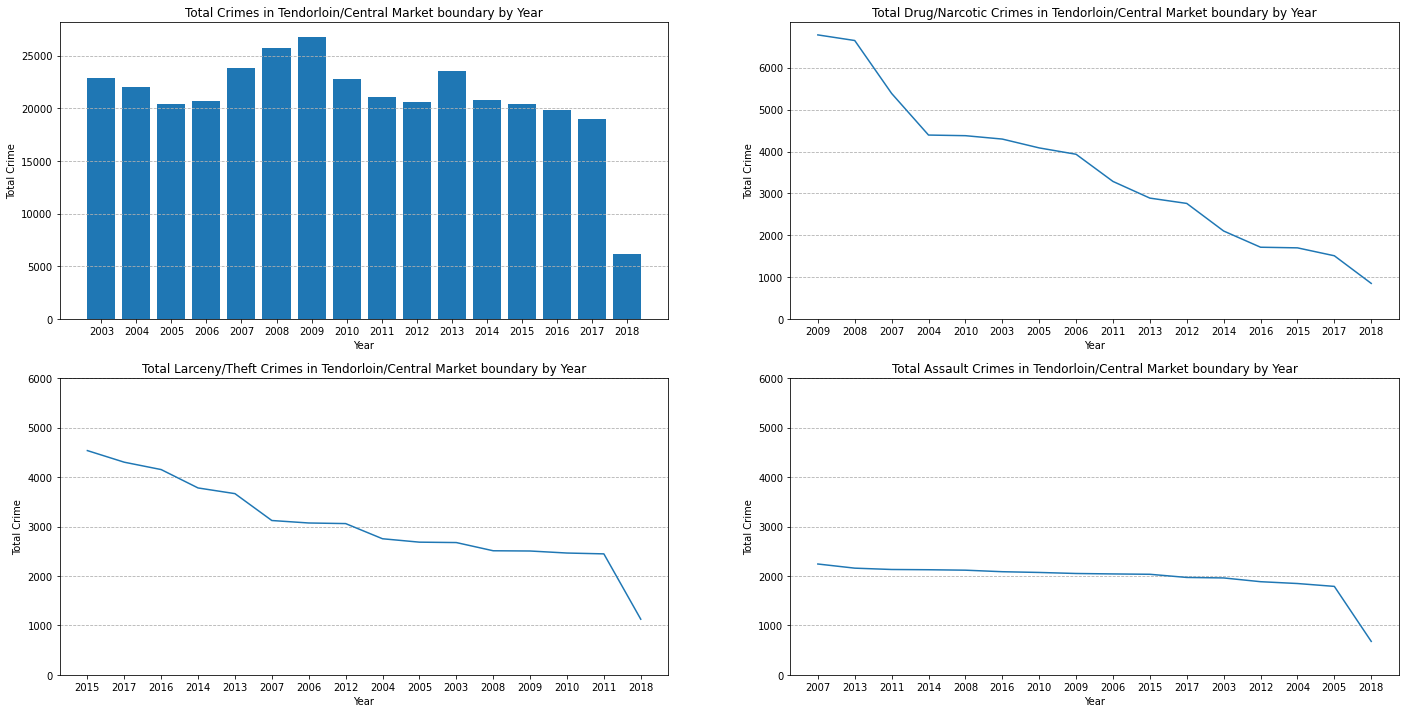

In [0]:
td_year=td_analyze.groupBy('the_year').agg(sum('num_of_crime').alias('num_of_crime')).orderBy('the_year',ascending=True)
td_year_pd=td_year.toPandas()

plt.figure(figsize=(24,12))
ax1=plt.subplot(2,2,1)
plt.bar(td_year_pd['the_year'],td_year_pd['num_of_crime'])
plt.xlabel('Year')
plt.ylabel('Total Crime')
plt.grid(axis='y',linestyle='--')
plt.title('Total Crimes in Tendorloin/Central Market boundary by Year')

ax2=plt.subplot(2,2,2)
td_year1=td_analyze.filter(td_analyze.category=="DRUG/NARCOTIC")
td_year_pd1=td_year1.toPandas()
plt.plot(td_year_pd1['the_year'],td_year_pd1['num_of_crime'])
plt.xlabel('Year')
plt.ylabel('Total Crime')
plt.grid(axis='y',linestyle='--')
plt.yticks(np.arange(0,7000,1000))
plt.title('Total Drug/Narcotic Crimes in Tendorloin/Central Market boundary by Year')


ax3=plt.subplot(2,2,3)
td_year3=td_analyze.filter(td_analyze.category=="LARCENY/THEFT")
td_year_pd3=td_year3.toPandas()
plt.plot(td_year_pd3['the_year'],td_year_pd3['num_of_crime'])
plt.xlabel('Year')
plt.ylabel('Total Crime')
plt.grid(axis='y',linestyle='--')
plt.yticks(np.arange(0,7000,1000))
plt.title('Total Larceny/Theft Crimes in Tendorloin/Central Market boundary by Year')


ax4=plt.subplot(2,2,4)
td_year4=td_analyze.filter(td_analyze.category=="ASSAULT")
td_year_pd4=td_year4.toPandas()
plt.plot(td_year_pd4['the_year'],td_year_pd4['num_of_crime'])
plt.xlabel('Year')
plt.ylabel('Total Crime')
plt.grid(axis='y',linestyle='--')
plt.yticks(np.arange(0,7000,1000))
plt.title('Total Assault Crimes in Tendorloin/Central Market boundary by Year')


Based on the analysis, looking at the crime in central market/tenderloin boundary specificly, the overall number of crime decreased in recent years, starting 2013, making this area safer than before. 

Looking at the crime categories, drug/narcotic is the major crime in this area. There are over 6000 crimes per year in 2008 and 2009. But thanks to the police, this number dropped significantly starting 2010, and it's already less than 1000 in 2018.

Larceny/Theft is the second major crime in this area, and there's a significant increase in volume in recent years. It should be the next focus for SFPD. 

Assault related crimes in this area is very steady in terms of the volume over the years, remaining to be around 2000 per year.

### Conclusion



#### Discover and suggestions
In order to provide a grading in terms of safety for citizen and tourists for San Francisco, we did a thorough OLAP analysis on the incident reports historical data of San Francisco police department. 

Using Spark SQL to clean and analyze the database, and using Pyspark data visulization tools, we identified the top three most dangerous districts are Southern, Mission, and Northern districts, with huge number of larceny/theft, expecially at noon and in the evening. We suggest touriests and citizen should be more careful and pay attention to their belongings when having activities in these areas.

In addition, we noticed that central market/tenderloin boundary is another area with huge number of crimes and drug related crimes are the major one there. Since it's very close to the tourist spots in San Francisco, we think tourists should be very careful when exploring in that downtown area. However, we do observed an significant decrease in the number of drug related crime thanks to the good work done by SFPD. Recently there are more and more theft related crime starting 2015, which should be the next target police should focus on.

### Appendix

In [0]:
## helper function to transform the date, choose your way to do it. 
# refer: https://jaceklaskowski.gitbooks.io/mastering-spark-sql/spark-sql-functions-datetime.html

# Method 1: Using UDF within the system
# from pyspark.sql.functions import to_date, to_timestamp, hour
# df_opt1 = df_opt1.withColumn('Date', to_date(df_opt1.OccurredOn, "MM/dd/yy"))
# df_opt1 = df_opt1.withColumn('Time', to_timestamp(df_opt1.OccurredOn, "MM/dd/yy HH:mm"))
# df_opt1 = df_opt1.withColumn('Hour', hour(df_opt1['Time']))
# df_opt1 = df_opt1.withColumn("DayOfWeek", date_format(df_opt1.Date, "EEEE"))

## Method 2: 手工写udf 
#from pyspark.sql.functions import col, udf
#from pyspark.sql.functions import expr
#from pyspark.sql.functions import from_unixtime

#date_func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())
#month_func = udf (lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y/%m'), StringType())

#df = df_opt1.withColumn('month_year', month_func(col('Date')))\
#           .withColumn('Date_time', date_func(col('Date')))

## 方法3 手工在sql 里面
# select Date, substring(Date,7) as Year, substring(Date,1,2) as Month from sf_crime


## 方法4: 使用系统自带
# from pyspark.sql.functions import *
# df_update = df_opt1.withColumn("Date", to_date(col("Date"), "MM/dd/yyyy")) ##change datetype from string to date
# df_update.createOrReplaceTempView("sf_crime")
# crimeYearMonth = spark.sql("SELECT Year(Date) AS Year, Month(Date) AS Month, FROM sf_crime")